Recently I was reading the paper: **A Neural Probabilistic Language Model** from Yoshua Bengio: http://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf, which is the milestone of using Neural Network for Language Model. Traditionally, we multiply the chain of conditional probablity to estimate the probablity of the next word: **Pˆ(w1)=∏Pˆ(wt|w1 )**. However, the problem is in real world text, we got hundreds and thousands of words, which makes our calculation very expensive. One work around is to apply **n-gram** technique, which is basically just to estimate the probability using recent n words. What Yoshua Bengio did is using a neural network to build the language model, I believe later work such as **Word2vec** has some similar spirit to this work, so I decided to build  NNLM from scratch to understand it better.

According to the paper the overall approach is as the follows:

1. associate with each word in the vocabulary a distributed word feature vector (a real- valued vector in Rm),
2. express the joint probability function of word sequences in terms of the feature vectors of these words in the sequence, and
3. learn simultaneously the word feature vectors and the parameters of that probability function.

So to get the next word unnormalized log probablity of each word, we simply calculate the following :
    
    
    y = b + W x + U tanh(d + H x)
    
    
in which the weight matrices:H,U,W and the biases: b,d are learned from the neural network.
After we get y, we find the normalized probability using through `softmax(y)`

In [1]:
import numpy as np
from numpy import newaxis
import time
import matplotlib.pyplot as plt
from tqdm import tqdm
import re

In [2]:
def oheY(Y,idx2word):
    ncol = len(idx2word.keys())
    nrow = len(Y)
    OHE_Y = np.zeros((nrow,ncol))
    for r in range(len(Y)):
        if not isinstance(Y[r],list):
            OHE_Y[r,Y[r]] = 1
        else:
            row_val = Y[r]
            for c in row_val:
                OHE_Y[r,c] = 1
                
    return OHE_Y
        

    
def tokenize(x_list,word2idx,START_TOKEN,END_TOKEN):
    #unique tokens:
    unique_x = list(set([j for i in x_list for j in i]))
    
    for w in unique_x:
        if w not in word2idx:
            word2idx[w] = len(word2idx)
    
    
        
    idx2word = {i[1]:i[0] for i in word2idx.items()}
    # Encode:
    tokened_x_list = []
    for sentence in x_list:
        temp_sent = []
        for word in sentence:
            token = word2idx.get(word,-1)
            temp_sent.append(token)
        
        tokened_x_list.append(temp_sent)
    return tokened_x_list,idx2word,word2idx
            

    

            
            

        
def softmax(x):
    e_x = np.exp(x)
    return np.divide(e_x,e_x.sum(axis=1).reshape(-1,1))
            
            

def sigmoid(x):
    
    return 1/(1+np.exp(-x))
    
    

    
def training_data_prep(x_list,n):
    """

    
    Arguments:
        x_list(list): tokenized training data
        
        n: numbers of context word to look at to predict the next word
    
    Returns:
        processd_data(list):  a list of tuples represents the processed data. Each pair of tuple is a (x,y) pair
        
    """
    X = []
    Y = []
    
    for row in x_list:
        row_len = len(row)
        for i in range(n,row_len):
       

            X.append(row[(i-n):i])
            Y.append(row[i])

     
    
    return X,Y
            
    

    
    
def tanh(x,if_derivative=False):
    
    if if_derivative:
        return 1 - np.tanh(x)*np.tanh(x)
    else:
        return np.tanh(x)
    
    

    
def cross_entropy(y,y_hat):
    return -np.sum(y*np.log(y_hat+1e-9))/len(y)
    
    

    
def text_clean(x_string):
    x_string = x_string.lower()
    x_string = re.sub(r'[\w\.-]+@[\w\.-]+(\.[\w]+)+','',x_string)
    x_string = x_string.replace("\n"," ")
    x_string = x_string.replace("\t"," ")

    x_string = re.sub(r'[^\s\w_]+',' ',x_string)

    return x_string

In [255]:

data = [
    'apple and banana are delicious food',
    'I love play video game in game studio',
    'i have orc warrior in world of warcraft',
    'super mario is the best video game ever',
    'is warcraft and world of warcraft the same game',
    'icecream is too sweet for a meal',
    'dove chocolate is my favorite',
    'which is sweet chocolate or icecream',
    'chocolate or banana or icecream is the most delicious food',
    'go to buy a banana bread for my lunch',
    'banana apple smoothie is the best for lunch',
    'chocolate icecream taste more delicious than banana',
    'chicken sandwich is different from chicken bread',
    'The present tense is more common in writing', 
    'As you can see by all the explanations I give', 
    'Instructional writing is more commonly written in present tense',
    'I want to make sure everyone is ready for the field trip next week',
    'I find it rather difficult to pick one that leaves me with the fabled',
    'I had the pleasure of traveling across America in many moving trips',
    'The blazing, red, diesel fuel tanks beamed in front of the station, looking like cheap lipstick',
    'This family was a victim of a problem they could have avoided',
    'Do you think that schools should track students with tracking technology',
    'im writing an essay write now and im getting super confused',
    'Despite heading the Forbes list, Messi has endured a mixed season at the Catalan club',
    'The move comes ahead of a vote in the committee',
    'At least one federal court in a different, but related case, agreed with the administration',
    'tomorrow evening is probably a better time to work on the assignment',
    'do you think computer will replace human in the future',
    'I think school is the worst place'
]




#### Basic Text Clean

In [256]:
data = [text_clean(sent) for sent in data]
data = [sent.split(" ") for sent in data]
data = [[word for word in sent if len(word)>1] for sent in data]

#### Preprocessing:

For the preprocessing step, we add `start_token` and `end_token` and for the sentences

In [258]:
# START_TOKEN = '^'
# END_TOKEN = '$'

# data = [[START_TOKEN]+sent+[END_TOKEN] for sent in data]

# print(data[:3])

#### Tokenization:

In [259]:
init_dict = {START_TOKEN:0,END_TOKEN:1}

In [260]:
tokenized_data_list,idx2word,word2idx = tokenize(data,init_dict,START_TOKEN,END_TOKEN)

In [261]:
print(word2idx)

{'^': 0, '$': 1, 'by': 2, 'now': 3, 'leaves': 4, 'across': 5, 'meal': 6, 'most': 7, 'in': 8, 'court': 9, 'all': 10, 'see': 11, 'ahead': 12, 'blazing': 13, 'or': 14, 'technology': 15, 'of': 16, 'front': 17, 'replace': 18, 'list': 19, 'trips': 20, 'time': 21, 'orc': 22, 'im': 23, 'banana': 24, 'avoided': 25, 'dove': 26, 'trip': 27, 'tracking': 28, 'human': 29, 'do': 30, 'place': 31, 'with': 32, 'sure': 33, 'catalan': 34, 'lunch': 35, 'warrior': 36, 'pick': 37, 'from': 38, 'but': 39, 'as': 40, 'related': 41, 'future': 42, 'my': 43, 'make': 44, 'favorite': 45, 'looking': 46, 'problem': 47, 'present': 48, 'delicious': 49, 'work': 50, 'that': 51, 'explanations': 52, 'for': 53, 'sandwich': 54, 'station': 55, 'tomorrow': 56, 'love': 57, 'students': 58, 'written': 59, 'pleasure': 60, 'difficult': 61, 'to': 62, 'taste': 63, 'rather': 64, 'vote': 65, 'commonly': 66, 'they': 67, 'traveling': 68, 'want': 69, 'cheap': 70, 'has': 71, 'schools': 72, 'different': 73, 'this': 74, 'the': 75, 'beamed': 76

#### Prepare the Training Data:

To prepare the training data, we use n words before the target word to predict it, so we have the following output:

In [262]:
N = 3

In [263]:
X,Y = training_data_prep(tokenized_data_list,n=N)

In [396]:
for i in range(50):
    tmpx = [idx2word.get(idx) for idx in X[i]]
    tmpy = idx2word.get(Y[i])
    print(f"{tmpx} -> {tmpy}")

['apple', 'and', 'banana'] -> are
['and', 'banana', 'are'] -> delicious
['banana', 'are', 'delicious'] -> food
['love', 'play', 'video'] -> game
['play', 'video', 'game'] -> in
['video', 'game', 'in'] -> game
['game', 'in', 'game'] -> studio
['have', 'orc', 'warrior'] -> in
['orc', 'warrior', 'in'] -> world
['warrior', 'in', 'world'] -> of
['in', 'world', 'of'] -> warcraft
['super', 'mario', 'is'] -> the
['mario', 'is', 'the'] -> best
['is', 'the', 'best'] -> video
['the', 'best', 'video'] -> game
['best', 'video', 'game'] -> ever
['is', 'warcraft', 'and'] -> world
['warcraft', 'and', 'world'] -> of
['and', 'world', 'of'] -> warcraft
['world', 'of', 'warcraft'] -> the
['of', 'warcraft', 'the'] -> same
['warcraft', 'the', 'same'] -> game
['icecream', 'is', 'too'] -> sweet
['is', 'too', 'sweet'] -> for
['too', 'sweet', 'for'] -> meal
['dove', 'chocolate', 'is'] -> my
['chocolate', 'is', 'my'] -> favorite
['which', 'is', 'sweet'] -> chocolate
['is', 'sweet', 'chocolate'] -> or
['sweet', '

#### OHE:

To feed into the network, we need to `one-hot-encode` our X and Y:

In [265]:
ohe_Y = oheY(Y,idx2word)

In [266]:
X_train = []
for sent in X:
    X_train.append(oheY(sent,idx2word))
X_train = np.array(X_train)

#### Now let's start the NN Architecture:

now we have our data prepared for the model, note that we get rid of the biases for the simplicity

In [267]:
X;ohe_Y;idx2word;word2idx;

And parameters:

In [476]:
V = len(idx2word) # vocabulary size

In [477]:
h = 16 # number of hiddent units

In [478]:
m = 5 #5 embedding dimension

In [486]:
n_iter = 300 #300
alpha = 0.001

In [487]:
a = 1

In [488]:


C = np.random.normal(size=(V,m)) # embedding weight matrix




U = np.random.normal(size=(V,h)) # embedding weight matrix
W = np.random.normal(size=(V,N*m   )) # embedding weight matrix

H = np.random.normal(size=(h,N*m)) # Hidden Layer matrix 

d = np.zeros((1,h))

b = np.zeros((1,V))

In [489]:
LOSS = []

In [490]:
for iter in range(n_iter):
    
    # Forward Propagation:
    x0 = X_train.dot(C) # query the word vector from Word Embedding Layer:  MxNxH
    x = x0.reshape(x0.shape[0],-1) # Concat: Mx(N*H)
    hx = x.dot(H.T) + d#Mxh
    act_hx = tanh(hx,if_derivative=False)#Mxh
    U_act_hx = act_hx.dot(U.T) # MxV
    Wx = x.dot(W.T) #MxV
    
    add_all_x = b+Wx+U_act_hx
    output = softmax(add_all_x)
    loss = cross_entropy(ohe_Y,output)
    LOSS.append(loss)
    if iter%5==0:
        print(f"Loss--{loss}")
    
    
    # Backward Propagation

    #d_loss/d_add_all_x: (I hacked this step), d of cross_entropy+softmax is the subtraction
    d_add_all_x = output - ohe_Y
    
    
    d_b = d_add_all_x.sum(axis=0,keepdims=True)
    d_Wx = d_add_all_x.copy() # mxv
    d_U_act_hx = d_add_all_x.copy()
    
    #d_loss/d_w
    d_W = d_Wx.T.dot(x)
    #d_loss/d_U
    d_U = d_U_act_hx.T.dot(act_hx)
    #d_loss/d_act_hx
    d_act_hx = d_U_act_hx.dot(U)
    #d_loss/d_hx
    d_hx = d_act_hx* tanh(act_hx,if_derivative=True)
    #d_loss/d_H
    d_H = d_hx.T.dot(x)
   
    #d_loss/d_x
    d_x = d_hx.dot(H)

    #d_loss/d_d
    d_d = d_hx.sum(axis=0,keepdims=True)


    
    # reshap back
    d_x = d_x.reshape(x0.shape)


    #     d_loss/d_C
    d_C = np.zeros(C.shape) 
    for v in range(C.shape[0]):
        for w in range(C.shape[1]):
            d_C[v,w] = np.tensordot(d_X_embedding[:,:,w],X_train[:,:,v])




    C -= alpha*d_C
    U -= alpha*d_U
    W -= alpha*d_W
    H -= alpha*d_H
    d -= alpha*d_d
    b -= alpha*d_b

Loss--14.056023024923679
Loss--13.341058998834047
Loss--12.632042007867355
Loss--11.981858695556054
Loss--11.429418374507307
Loss--10.957535597872845
Loss--10.52879492619196
Loss--10.122839055458668
Loss--9.743512316584301
Loss--9.39730930438617
Loss--9.083354037011866
Loss--8.799498273915685
Loss--8.539225107942102
Loss--8.295292696900908
Loss--8.063266827986105
Loss--7.840909489726805
Loss--7.627451476964967
Loss--7.42363843856118
Loss--7.230214871300546
Loss--7.047177402633065
Loss--6.873703961682445
Loss--6.708297069763818
Loss--6.548997746092417
Loss--6.394100920816377
Loss--6.242815088334415
Loss--6.095622675208398
Loss--5.95357357474589
Loss--5.817165485727904
Loss--5.686026236454435
Loss--5.559475888367311
Loss--5.4370423083014465
Loss--5.318514128822914
Loss--5.203802485932598
Loss--5.092788992341444
Loss--4.985239766868958
Loss--4.880826580985282
Loss--4.77920557343942
Loss--4.6800870446229785
Loss--4.583267438185829
Loss--4.488598981549998
Loss--4.39594083437299
Loss--4.3051

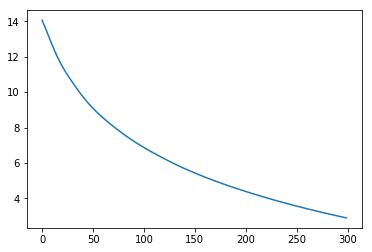

In [491]:
plt.plot(LOSS)

#### Training is done, let's now evaluate our NNLM to see how well it predicts text:

In [499]:
def predict(test_string,C=C,U=U,W=W,H=H,d=d,b=b,word2idx=word2idx):

    # FP one time using trained weight:
    test_list = test_string.split(" ")
    test_list = [[word2idx.get(i) for i in test_list]]
    X_test = []
    for sent in test_list:
        X_test.append(oheY(sent,idx2word))
    X_test = np.array(X_test)
    x0 = X_test.dot(C) # query the word vector from Word Embedding Layer
    x = x0.reshape(x0.shape[0],-1) # Concat: Mx(N*H)
    hx = x.dot(H.T) + d#Mxh
    act_hx = tanh(hx,if_derivative=False)#Mxh
    U_act_hx = act_hx.dot(U.T) # MxV
    Wx = x.dot(W.T) #MxV
    
    add_all_x = b+Wx+U_act_hx
    output = softmax(add_all_x)
    idxs = np.where(output==output.max())[1]
   
    return [idx2word.get(i) for i in idxs]




In [500]:
test_string = "taste more delicious"
predict(test_string)

['icecream']

In [501]:
test_string = "in world of"
predict(test_string)

['warcraft']

In [502]:
test_string = "icecream is too"
predict(test_string)

['sweet']

In [503]:
test_string = "everyone is ready"
predict(test_string)

['for']